In [1]:
import torch 
import torch.nn as nn
import numpy as np 
import os
from PIL import Image
from torchvision.transforms import v2
import torchvision.transforms as t
from sklearn.model_selection import train_test_split

#a list of resized images from the dataset in the form of tensors
images = [] 

transform = t.Compose([
    t.ToTensor(),
    v2.Resize(size=(300, 300)),
    v2.Grayscale()])

#transforming each image in the directory, appending the images to the images list
for root, dirs, files in os.walk("/kaggle/input/iam-handwriting-top50/data_subset/data_subset", topdown=False):
    for name in files:
        im = Image.open(os.path.join(root, name))
        im = transform(im)
        images.append(im)

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
#making sure the values are between 0 and 1
print(images[1])

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


In [3]:
#splitting the images list into train, test sets
X_train, X_test = train_test_split(images[:3000], test_size=0.3)
print(X_train[1].size())

torch.Size([1, 300, 300])


In [4]:
!nvidia-smi

Wed Jan 10 18:38:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim: int, lin1_hw: int=4, lin1_channels: int=264, output_channels: int=1, device: str='cuda'):
        """
        The constructor of the Generator part of the network.

        z_dim: the dimension of the input noise vector
        lin1_hw: the height, width of the feature map produced by the first, dense layer. defaults to 4
        lin1_channels: the number of channels in the output of the first, dense layer. defaults to 128
        output_channels: the number of channels in the output of the network. defaults to 1 
        device: the device to send the calculations to. defaults to 'cuda' 
        """
        super(Generator, self).__init__()  

        self.z_dim = z_dim
        self.lin1_channels = lin1_channels
        self.lin1_hw = lin1_hw
        self.output_channels = output_channels
        self.device = device

        self.G = nn.Sequential(
            nn.Linear(z_dim, lin1_channels, True, self.device),
            nn.LeakyReLU(0.1, True),
            
            nn.Linear(lin1_channels, lin1_channels * 2, True, self.device),
            nn.LeakyReLU(0.1, True),
            
            nn.Dropout(0.5, True),
            
            nn.Linear(lin1_channels * 2, lin1_channels * 3, True, self.device),
            nn.LeakyReLU(0.1, True),
            
            nn.Linear(lin1_channels * 3, lin1_channels * 4, True, self.device),
            nn.LeakyReLU(0.1, True),
            
            nn.Linear(lin1_channels * 4, 300, True, self.device),
            nn.Tanh()
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        The forward pass of the network.

        returns a tensor (an image).
        """
    
        return self.G(z)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_size:int=300, conv1_channels: int=64, device: str='cuda'):
        """
        The constructor of the Discriminator part of the network.
        
        input_channels: the number of channels in the input. defaults to 1
        conv1_channels: the number of channels in the output of the first conv layer. defaults to 64
        device: the device to perform the calculations on. defaults to 'cuda'
        """ 
        super(Discriminator, self).__init__()

        self.input_size = input_size
        self.conv1_channels = conv1_channels
        self.device = device

        self.D = nn.Sequential(
            nn.Linear(input_size, 128, True, self.device),
            nn.LeakyReLU(0.1, True),
            
            nn.Linear(128, 100, True, self.device),
            nn.LeakyReLU(0.1, True),
            
            nn.Linear(100, 64, True, self.device),
            nn.LeakyReLU(0.1, True),
            
            nn.Linear(64, 1, True, self.device),
            nn.Sigmoid()
        )

    
    def forward(self, x):

        return self.D(x)

In [7]:
noise_dim = 100

#generating a random noise matrix (a vector simply doesn't work)
z = torch.randn(noise_dim, noise_dim, device='cuda')
print(z.shape)

torch.Size([100, 100])


In [8]:
torch.cuda.empty_cache()

torch.Size([100, 300])


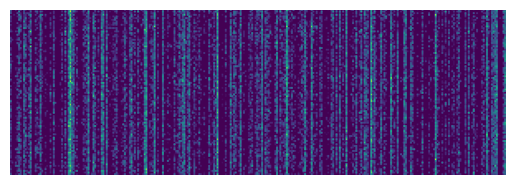

tensor([[0.5033],
        [0.5033],
        [0.5031],
        [0.5032],
        [0.5031],
        [0.5030],
        [0.5032],
        [0.5032],
        [0.5031],
        [0.5032],
        [0.5031],
        [0.5033],
        [0.5031],
        [0.5030],
        [0.5031],
        [0.5033],
        [0.5032],
        [0.5032],
        [0.5032],
        [0.5032],
        [0.5033],
        [0.5030],
        [0.5032],
        [0.5033],
        [0.5032],
        [0.5032],
        [0.5030],
        [0.5032],
        [0.5031],
        [0.5033],
        [0.5031],
        [0.5031],
        [0.5033],
        [0.5031],
        [0.5033],
        [0.5033],
        [0.5031],
        [0.5033],
        [0.5031],
        [0.5032],
        [0.5033],
        [0.5032],
        [0.5033],
        [0.5032],
        [0.5032],
        [0.5032],
        [0.5033],
        [0.5030],
        [0.5032],
        [0.5031],
        [0.5032],
        [0.5033],
        [0.5032],
        [0.5030],
        [0.5033],
        [0

In [9]:
import matplotlib.pyplot as plt 
G = Generator(noise_dim)
out = G.forward(z)
out = out.clamp(0, 1)  # Ensure values are in the valid range [0, 1]
#out = out.expand(3, -1, -1)
pil_image = t.ToPILImage()(out)
print(out.size())

# Display the PIL image using matplotlib
plt.imshow(pil_image)
plt.axis('off')  # Turn off axis labels
plt.show()

D = Discriminator()
print(D.forward(out))